In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta
import datetime as dt
import warnings

### Задание 1. Написать функцию для подсчета показателя retention в днях

Выгрузим наши данные и рассмотрим их подробнее. Проверим количество уникальных пользователей, типы данных, наличие пропущенных значений

In [3]:
reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-lisogor/shared/problem1-reg_data.csv', sep = ';')
auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-lisogor/shared/problem1-auth_data.csv', sep = ';')

In [4]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
reg['uid'].nunique()

1000000

In [8]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [10]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
auth['uid'].nunique()

1000000

Приведем типы данных к необходимому формату и посмотрим, за какой период у нас данные. Сразу видим, что период у нас большой, поэтому есть смысл в функции указывать начальную и конечную даты, за которые мы будем анализировать retantion

In [12]:
reg.reg_ts = pd.to_datetime(reg.reg_ts, unit='s')
auth.auth_ts = pd.to_datetime(auth.auth_ts, unit='s')

In [13]:
print(f"Дата первой регистрации {reg.reg_ts.min()}")
print(f"Дата последней регистрации {reg.reg_ts.max()}")

Дата первой регистрации 1998-11-18 09:43:43
Дата последней регистрации 2020-09-23 15:17:24


In [14]:
print(f"Дата первой игровой сессии {auth.auth_ts.min()}")
print(f"Дата последней игровой сессии {auth.auth_ts.max()}")

Дата первой игровой сессии 1998-11-18 09:43:43
Дата последней игровой сессии 2020-09-23 15:17:24


###### Напишем функцию, которая будет показывать нам retention за выбранные дни

In [15]:
def retention (start_date, end_date):
    #Установим начальную и конечную дату, за которые мы будем смотреть данные
    start_date = pd.to_datetime(start_date, utc=False)
    end_date = pd.to_datetime(end_date, utc=False)
    
    #Приведем данные о времени регистрации и о времени захода пользователя в игру к типу datetime в днях
    reg['reg_ts'] = pd.to_datetime(reg['reg_ts']).dt.date
    auth['auth_ts'] = pd.to_datetime(auth['auth_ts']).dt.date
    
    #Выберем только те данные, которые соответствуют выбранным дням
    reg_dates = reg.query('reg_ts >= @start_date')
    auth_dates = auth.query('auth_ts <= @end_date')
    
    # объединяем наши данные с временем регистрации и данные о времени захода пользователей в игру
    users_data = auth_dates.merge(reg_dates, on = 'uid', how = 'left')
    
    #Добавим колонку, которая посчитает, сколько дней прошло с момента регистрации до захода пользователя в игру
    users_data['time_delta'] = (users_data['auth_ts'] - users_data['reg_ts']).dt.days
    
    #Объединим наших пользователей по дням
    retention_day = users_data\
    .groupby(['reg_ts', 'time_delta'], as_index = False)\
    .agg({'uid' : 'nunique'})\
    .rename(columns={'reg_ts':'cohort', 'time_delta':'days_from_registration', 'uid':'users'})\
    .pivot(index = 'cohort', columns = 'days_from_registration', values = 'users')
    
    retention_day=(retention_day.div(retention_day[0], axis='index'))
    retention_day = retention_day.drop([0],axis = 1)
    
    #Оформим визуальное представление
    retention = (retention_day
            .style
            .background_gradient(cmap='Blues')
            .highlight_null('white')
            .format('{:.2%}', na_rep=' '))
    

    return retention

###### Проверим работу функции на периоде в 10 дней

In [16]:
retention('2016-01-01', '2016-01-10')

days_from_registration,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
cohort,,,,,,,,,
2016-01-01,2.08%,1.04%,3.12%,5.21%,11.46%,6.25%,11.46%,2.08%,5.21%
2016-01-02,5.15%,3.09%,4.12%,4.12%,3.09%,4.12%,6.19%,3.09%,
2016-01-03,,4.17%,3.12%,10.42%,9.38%,5.21%,10.42%,,
2016-01-04,1.03%,2.06%,5.15%,3.09%,4.12%,8.25%,,,
2016-01-05,1.04%,6.25%,7.29%,5.21%,12.50%,,,,
2016-01-06,2.06%,4.12%,6.19%,3.09%,,,,,
2016-01-07,1.03%,5.15%,4.12%,,,,,,
2016-01-08,1.03%,10.31%,,,,,,,
2016-01-09,1.02%,,,,,,,,


Проведем небольшое исследование нашей мобильной игры. Посмотрим, как менялось количество игроков по годам, стали ли в нее заходить чаще

Объединим наши таблицы и проанализируем данные в разрезе лет

In [17]:
game_users = auth.merge(reg, on = 'uid', how = 'left')

In [18]:
game_users.head()

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


In [19]:
game_users['reg_ts'] = pd.to_datetime(game_users['reg_ts']).dt.year
game_users['auth_ts'] = pd.to_datetime(game_users['auth_ts']).dt.year

In [20]:
auth_by_years = game_users\
    .groupby(['auth_ts'], as_index = False)\
    .agg({'uid' : 'count'})\
    .rename(columns={'auth_ts':'year', 'uid':'authorizations'})

In [21]:
reg_by_years = game_users\
    .groupby(['reg_ts'], as_index = False)\
    .agg({'uid' : 'nunique'})\
    .rename(columns={'reg_ts':'year', 'uid':'registrations'})

In [22]:
mobile_game = auth_by_years.merge(reg_by_years, how = 'left')
mobile_game

,year,authorizations,registrations
0,1998,1,1
1,1999,38,1
2,2000,94,4
3,2001,94,6
4,2002,125,10
5,2003,142,20
6,2004,182,35
7,2005,289,65
8,2006,731,119
9,2007,1502,216


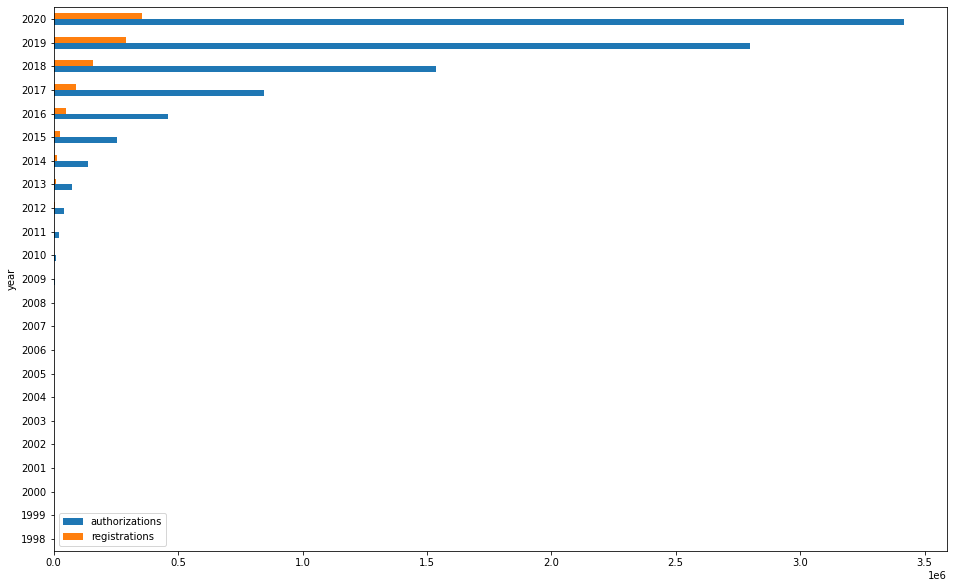

In [23]:
mobile_game.plot.barh(x="year", y=["authorizations", "registrations"], figsize=(16, 10))

Видим, что наша игра с 1998 по 2012 год была известна лишь в узких кругах, а с 2012 ее популярность стала постоянно расти и число регистраций в 2020 году достигло 350 тысяч, а количество игровых сессий приблизилось к 3,5 миллионам.

In [24]:
avg_session = game_users\
    .groupby(['uid'], as_index = False)\
    .agg({'auth_ts':'count'})\
    .sort_values(by = 'auth_ts', ascending = False)

Наши топ-5 пользователей, которые чаще всех заходят в игру

In [25]:
avg_session.head(5)

,uid,auth_ts
1,2,1929
99,108,1397
148,158,1367
163,176,1331
175,191,1296


In [26]:
user_2 = game_users\
    .query('uid == "2"')\
    .groupby(['uid', 'reg_ts'], as_index = False)\
    .agg({'auth_ts':'count'})\

А это наш победитель, который зарегистрировался в 1999 году и заходил в нее больше всех остальных

In [27]:
user_2

,uid,reg_ts,auth_ts
0,2,1999,1929
